# Logistic Regression

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import regex as re

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import pickle

In [2]:
df = pd.read_csv('../anx_writing.csv').drop(columns = ['Unnamed: 0'], axis = 1)

In [3]:
df.head()

,author,link_flair_text,num_comments,subreddit,created_utc,text
0,JackW357,DAE Questions,9,Anxiety,1606687976,Anyone else scared of dying and scared of when...
1,belladoll1021,Health,1,Anxiety,1606687615,Tight throat Can a tight throat and gagging fe...
2,ashwinderegg,Advice Needed,3,Anxiety,1606687588,Anxiety overriding my intuition. Does anyone e...
3,ashwinderegg,Advice Needed,7,Anxiety,1606687588,Anxiety overriding my intuition. Does anyone e...
4,lachapoxxx,Advice Needed,1,Anxiety,1606687488,hey friends! i need some advice my anxiety has...


### Baseline Accuracy

In [4]:
df['subreddit'].value_counts(normalize = True)

Anxiety    0.5
writing    0.5
Name: subreddit, dtype: float64

In [5]:
#Add to the list of stopwords
stop = stopwords.words('english')

#These words were chosen through eda and from a warning from previously running program
new_words= ['anxiety', 'anxious','writing','arent', 'couldnt', 'didnt', 'doesnt', 'dont', 'hadnt', 'hasnt', 'havent', 'isnt', 'mightnt', 'mustnt', 'neednt', 'shant', 'shes', 'shouldnt', 'shouldve', 'thatll', 'wasnt', 'werent', 'wont', 'wouldnt', 'youd', 'youll', 'youre', 'youve', 'im', 'doe', 'ha', 'wa']

for i in new_words:
    stop.append(i)

#Copied from https://stackoverflow.com/questions/5511708/adding-words-to-nltk-stoplist

In [6]:
def custom_preprocessor (text):
    text = text.lower() #lowercases word
    text = re.sub(r'[^\w\s]', '', text) #removes punctuation
    text = re.sub(r'[0–9]', '', text) #removes any numbers
    text = re.sub('(<.*?>)', '', text) #removed html
    #copied from https://swatimeena989.medium.com/beginners-guide-for-preprocessing-text-data-f3156bec85ca
    
    lemmatizer = WordNetLemmatizer()
    text = lemmatizer.lemmatize(text)
    
    return text

#copied from https://www.studytonight.com/post/scikitlearn-countvectorizer-in-nlp

In [7]:
# Turn subreddit column to 1 if anxiety and 0 if writing.
df['subreddit'] = df['subreddit'].map({'Anxiety': 'Anxiety', 'writing': 'No Anxiety'})

In [8]:
X = df['text']
y = df['subreddit']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.7, stratify = y)

In [10]:
pipe = Pipeline([
    ('tf', TfidfVectorizer(stop_words = stop, 
                           strip_accents = 'ascii', 
                           ngram_range = (1, 3),
                           preprocessor = custom_preprocessor,
                           min_df = 2,
                           max_features = 50000)),
    ('logr', LogisticRegression())
])

In [11]:
params = {
    'logr__penalty':['l1', 'l2', 'elasticnet'],
    'logr__solver': ['liblinear', 'sag', 'saga'],
    'logr__max_iter': [1000, 2000, 3000],
    'logr__C': [1, 2, 3]
}

grid = GridSearchCV(pipe, params, cv = 5, n_jobs = -1, verbose = 1)

In [14]:
%%time
grid.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


/Users/admin/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.91761905        nan 0.91809524 0.94190476 0.94190476 0.94190476
        nan        nan        nan 0.91761905        nan 0.91785714
 0.94190476 0.94190476 0.94190476        nan        nan        nan
 0.91761905        nan 0.91785714 0.94190476 0.94190476 0.94190476
        nan        nan        nan 0.9297619         nan 0.9297619
 0.94547619 0.94547619 0.94547619        nan        nan        nan
 0.9297619         nan 0.9297619  0.94547619 0.94547619 0.94571429
        nan        nan        nan 0.9297619         nan 0.9297619
 0.94547619 0.94547619 0.94547619        nan        nan        nan
 0.9352381         nan 0.9352381  0.94761905 0.94761905 0.94761905
        nan        nan        nan 0.9352381         nan 0.9352381
 0.94761905 0.94761905 0.94761905        nan        nan        nan
 0.9352381         nan 0.9352381  0

CPU times: user 8.85 s, sys: 1.94 s, total: 10.8 s
Wall time: 16min 35s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf',
                                        TfidfVectorizer(max_features=50000,
                                                        min_df=2,
                                                        ngram_range=(1, 3),
                                                        preprocessor=<function custom_preprocessor at 0x7f8fa542d820>,
                                                        stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                      

In [15]:
def model_metrics(model, X_train, X_test):
    
    print(f'Best Score: {model.best_score_}')
    print(f'Best Parameters: {model.best_params_}')
    print(f'Train Score: {model.score(X_train, y_train)}')
    print(f'Test Score: {model.score(X_test, y_test)}')

In [18]:
model_metrics(grid, X_train, X_test)

Best Score: 0.9476190476190476
Best Parameters: {'logr__C': 3, 'logr__max_iter': 1000, 'logr__penalty': 'l2', 'logr__solver': 'liblinear'}
Train Score: 0.9928571428571429
Test Score: 0.9505555555555556


In [19]:
def plot_matrix(model, X_test):
    
    preds = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
    fig, ax = plt.subplots(figsize=(7, 7))
    
    # View confusion matrix
    plot_confusion_matrix(model, X_test, y_test, cmap = 'copper', values_format='d', ax = ax)
    
    # Labels, title and ticks
    label_font = {'size':'15'}  # Adjust to fit
    ax.set_xlabel('Predicted labels', fontdict=label_font);
    ax.set_ylabel('Observed labels', fontdict=label_font);

    title_font = {'size':'21'}  # Adjust to fit
    ax.set_title('Confusion Matrix', fontdict=title_font);

    ax.tick_params(axis='both', which='major', labelsize=12) 
    
#Copied from https://stackoverflow.com/questions/59839782/confusion-matrix-font-size

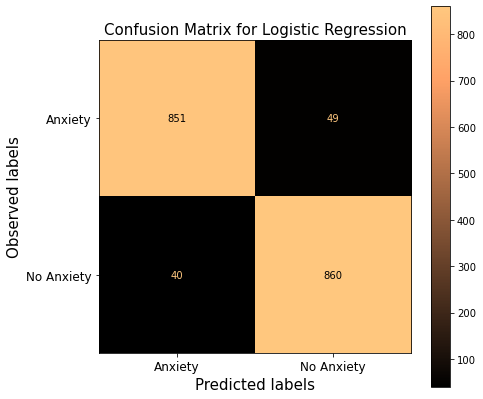

In [20]:

plot_matrix(grid, X_test)
plt.title('Confusion Matrix for Logistic Regression', fontsize = 15);

In [24]:
tvec = grid.best_estimator_.named_steps['tf']
log = grid.best_estimator_.named_steps['logr']
#Copied from https://stackoverflow.com/questions/43856280/return-coefficients-from-pipeline-object-in-sklearn

coef_df = pd.DataFrame(log.coef_, columns = tvec.get_feature_names()).T
coef_df['coefficient'] = coef_df[0]
coef_df.drop(columns = 0, inplace = True)
coef_df.head()

,coefficient
11,0.104043
11 pounds,-0.039590
11 words,0.058114
11 year,-0.037556
11 years,0.066404


In [25]:
coef_df.sort_values(by = 'coefficient', ascending = False).head(25)

,coefficient
write,8.959610
story,8.031821
character,5.801021
characters,4.943415
book,4.882909
novel,4.451965
writer,4.215437
writers,3.885995
stories,3.434192
books,3.130652


In [26]:
coef_df.sort_values(by = 'coefficient').head(25)

,coefficient
feel,-5.863544
feeling,-4.653816
scared,-4.275327
panic,-4.245113
attack,-4.241795
cant,-4.190334
talk,-3.475479
anyone,-3.398797
get,-3.340801
going,-3.162740


In [28]:
with open('./models/anxiety_log.pkl', 'wb') as pickle_out:
    pickle_out = pickle.dump(grid, pickle_out)